In [ ]:
%pip -q install --upgrade --no-cache-dir \
  "numpy==1.26.4" \
  "scipy==1.12.0" \
  "pandas==2.2.2" \
  "gensim==4.3.2" \
  kagglehub

In [13]:
#import libraries and define cosine similarity function to compare 2 vectors, and vocabulary checker

import gensim
import gensim.downloader as api
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import os, re, json, warnings

import pandas as pd
from gensim.utils import simple_preprocess
import kagglehub

#cosine similarity for vectors
def cosine(u, v):
    u = np.asarray(u); v = np.asarray(v)
    return np.dot(u, v) / (norm(u) * norm(v))

#check vocab membership (avoids KeyErrors)
def in_vocab(model, word: str) -> bool:
    return word in model.key_to_index

model = api.load("glove-wiki-gigaword-100")

In [14]:
#try King Queen starter example

print("Built-in most_similar (king - man + woman):")
print(model.most_similar(positive=["king", "woman"], negative=["man"], topn=10))

#manual vector arithmetic + direct similarity to 'queen'
required = ["king", "man", "woman", "queen"]
missing = [w for w in required if not in_vocab(model, w)]
if missing:
    print("Missing words:", missing)
else:
    target = model["king"] - model["man"] + model["woman"]
    sim_to_queen = cosine(target, model["queen"])
    print("\nCosine(target, 'queen') =", sim_to_queen)

    # NN to the computed target vector
    print("\nNearest neighbors to king - man + woman:")
    print(model.similar_by_vector(target, topn=10))

Built-in most_similar (king - man + woman):
[('queen', 0.7698540687561035), ('monarch', 0.6843381524085999), ('throne', 0.6755736470222473), ('daughter', 0.6594556570053101), ('princess', 0.6520534157752991), ('prince', 0.6517034769058228), ('elizabeth', 0.6464517712593079), ('mother', 0.631171703338623), ('emperor', 0.6106470823287964), ('wife', 0.6098655462265015)]

Cosine(target, 'queen') = 0.7834413

Nearest neighbors to king - man + woman:
[('king', 0.8551837205886841), ('queen', 0.783441424369812), ('monarch', 0.6933802366256714), ('throne', 0.6833109855651855), ('daughter', 0.6809081435203552), ('prince', 0.6713141798973083), ('princess', 0.664408266544342), ('mother', 0.6579325795173645), ('elizabeth', 0.6563301086425781), ('father', 0.6392418742179871)]


In [15]:
tests = [
    (["paris", "italy"], ["france"]),
    (["rome", "germany"], ["italy"]),
    (["london", "france"], ["england"]),

    (["king", "woman"], ["man"]),
    (["actor", "woman"], ["man"]),
    (["brother", "woman"], ["man"]),

    (["walking", "swim"], ["walk"]),
    (["better", "bad"], ["good"]),
    (["went", "go"], ["was"]),
]

def show_analogy_nn(wordModel, w1, w2, w3, topn):
    words = [w1.lower(), w2.lower(), w3.lower()]
    oov = [w for w in words if w not in wordModel.key_to_index]
    if oov:
        print("out-of-vocab words:", oov)
        return None

    target = wordModel[words[0]] + wordModel[words[1]] - wordModel[words[2]]
    #nearest neighbors to the computed target vector
    nn = wordModel.similar_by_vector(target, topn=topn)
    print(f"\nTop {topn} nearest to {w1} + {w2} - {w3}:")
    for rank, (word, score) in enumerate(nn, 1):
        print(f"{rank:2d}. {word:15s}  {score:.4f}")
    return nn, target

show_analogy_nn(model, tests[0][0][0], tests[0][0][1], tests[0][1][0], topn=10)


Top 10 nearest to paris + italy - france:
 1. rome             0.8084
 2. milan            0.7317
 3. italy            0.7273
 4. naples           0.7090
 5. venice           0.7010
 6. turin            0.6970
 7. paris            0.6912
 8. italian          0.6649
 9. vienna           0.6573
10. genoa            0.6455


([('rome', 0.80840003490448),
  ('milan', 0.7316668629646301),
  ('italy', 0.7273259162902832),
  ('naples', 0.7089514136314392),
  ('venice', 0.7009831666946411),
  ('turin', 0.6969642639160156),
  ('paris', 0.6911898255348206),
  ('italian', 0.6648708581924438),
  ('vienna', 0.657267689704895),
  ('genoa', 0.6454700231552124)],
 array([ 9.86690044e-01, -2.82990009e-01, -1.24819994e-01,  6.37120008e-01,
         1.13677025e-01,  4.38800007e-01, -2.29270011e-01,  3.45400035e-01,
        -7.06244931e-02,  6.41424000e-01,  1.00866902e+00, -5.95366955e-01,
        -5.35790026e-01,  3.59219968e-01, -6.41409993e-01,  8.71109962e-02,
         5.88940024e-01, -5.67990065e-01, -5.41670024e-01, -8.03099871e-02,
        -2.91660994e-01,  3.19939971e-01,  1.34416997e-01,  6.06770039e-01,
        -4.08670008e-01, -1.01249993e+00, -7.21900016e-02, -5.94089985e-01,
         2.69939899e-01, -3.68029952e-01, -6.26110017e-01, -4.34630036e-01,
        -1.11200005e-01,  3.94430041e-01, -4.42039967e-01,  

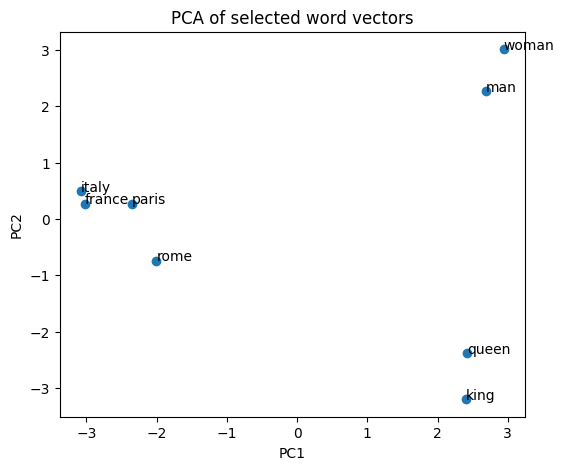

In [16]:
words = ["king", "queen", "man", "woman", "paris", "france", "rome", "italy"]
words = [w for w in words if in_vocab(model, w)]

def plot2DGraph(wordArray):
  X = np.array([model[w] for w in wordArray])
  pca = PCA(n_components=2) #compact into 2 dimensions
  X2 = pca.fit_transform(X)

  plt.figure(figsize=(6, 5))
  plt.scatter(X2[:, 0], X2[:, 1])
  for i, w in enumerate(wordArray):
      plt.annotate(w, (X2[i, 0], X2[i, 1]))
  plt.title("PCA of selected word vectors")
  plt.xlabel("PC1")
  plt.ylabel("PC2")
  plt.show()

plot2DGraph(words)

Now we will train our own vector embedding space based on tweets from the 2016 USA federal election. We start with data preprocessing where we extract the content of the tweets, remove unhelpful text (like links and mentions) and tokenize each tweet into individual words.

In [17]:
#preparing/cleaning tweet data

print("Downloading dataset (or using cache) ...")
path = kagglehub.dataset_download("fivethirtyeight/russian-troll-tweets")
print("Dataset path:", path)

#find all the IRAhandle_tweets_*.csv files
csv_files = sorted(
    [os.path.join(path, f) for f in os.listdir(path)
     if f.lower().startswith("irahandle_tweets_") and f.lower().endswith(".csv")]
)

if not csv_files:
    #if the naming ever differs, fall back to any .csv in the folder
    print("Could not find files")
    csv_files = sorted([os.path.join(path, f) for f in os.listdir(path) if f.lower().endswith(".csv")])

if not csv_files:
    raise FileNotFoundError(f"No CSV files found in {path}")

print(f"Found {len(csv_files)} CSV file(s):")
for f in csv_files:
    print(" -", os.path.basename(f))

dfs = [pd.read_csv(f, low_memory=False) for f in csv_files]
df = pd.concat(dfs, ignore_index=True)
print("Combined dataframe shape:", df.shape)

if "content" not in df.columns:
    raise ValueError(f"'content' column not found. Available columns: {list(df.columns)}")

#build raw texts list (one tweet per entry)
texts_raw = (
    df["content"]
    .astype(str)
    .str.strip()
)
#drop empties
texts_raw = texts_raw[texts_raw.str.len() > 0].tolist()

print(f"Total non-empty tweets: {len(texts_raw):,}")
print("Example raw tweet:", texts_raw[0][:160])

#minimal Twitter-aware cleaning and tokenization
url_pat     = re.compile(r"http\S+|www\.\S+", re.IGNORECASE)
mention_pat = re.compile(r"@\w+")
rt_pat      = re.compile(r"\brt\b", re.IGNORECASE)

def clean_and_tokenize(text: str):
    s = text.lower()
    s = url_pat.sub(" ", s)      # remove URLs
    s = mention_pat.sub(" ", s)  # remove @mentions
    s = rt_pat.sub(" ", s)       # remove standalone 'rt'
    # keep hashtag words; simple_preprocess strips '#' but keeps word
    return simple_preprocess(s, deacc=True, min_len=2, max_len=30)

# tokenize: List[List[str]] = one tokenized tweet per entry
tokenized_tweets = [clean_and_tokenize(t) for t in texts_raw]
tokenized_tweets = [tw for tw in tokenized_tweets if tw]  # drop empties

#stats
vocab_counts = {}
for tw in tokenized_tweets:
    for tok in tw:
        vocab_counts[tok] = vocab_counts.get(tok, 0) + 1

avg_len = float(np.mean([len(tw) for tw in tokenized_tweets])) if tokenized_tweets else 0.0

print("\nPrep complete")
print(f"Vocab size: {len(vocab_counts):,}")
print(f"Avg tokens per tweet: {avg_len:.2f}")
print(f"Tokenized tweets: {len(tokenized_tweets):,}")

#save preprocessed tokens
os.makedirs("./artifacts", exist_ok=True)
out_jsonl = "./artifacts/tokenized_tweets.jsonl"
with open(out_jsonl, "w", encoding="utf-8") as f:
    for tw in tokenized_tweets:
        f.write(json.dumps(tw, ensure_ascii=False) + "\n")
print("Saved preprocessed tweets to:", out_jsonl)

# Ready to feed into Word2Vec

Using Colab cache for faster access to the 'russian-troll-tweets' dataset.
Dataset path: /kaggle/input/russian-troll-tweets
Found 9 CSV file(s):
 - IRAhandle_tweets_1.csv
 - IRAhandle_tweets_2.csv
 - IRAhandle_tweets_3.csv
 - IRAhandle_tweets_4.csv
 - IRAhandle_tweets_5.csv
 - IRAhandle_tweets_6.csv
 - IRAhandle_tweets_7.csv
 - IRAhandle_tweets_8.csv
 - IRAhandle_tweets_9.csv
Combined dataframe shape: (2973371, 15)
Total non-empty tweets: 2,973,371
Example raw tweet: "We have a sitting Democrat US Senator on trial for corruption and you've barely heard a peep from the mainstream media." ~ @nedryun https://t.co/gh6g0D1oiC

Prep complete
Vocab size: 593,799
Avg tokens per tweet: 10.48
Tokenized tweets: 2,922,589
Saved preprocessed tweets to: ./artifacts/tokenized_tweets.jsonl


Now that the data is ready, we will train Word2Vec to get a dictionary that contains each word present in the tweets with a corresponding vector.

In [18]:
from gensim.models import Word2Vec

RANDOM_SEED = 42
VECTOR_SIZE = 100
WINDOW      = 5     # context window
MIN_COUNT   = 2     # keep tokens that appear at least 2 times
SG          = 0     # 1=Skip-gram, 0=CBOW
NEGATIVE    = 5    # negative samples
EPOCHS      = 5    # bump to 15–20 if you want a bit more quality
SUBSAMPLE   = 1e-3    # downsample very frequent words

w2v = Word2Vec(
    sentences=tokenized_tweets,
    vector_size=VECTOR_SIZE,
    window=WINDOW,
    min_count=MIN_COUNT,
    sg=SG,
    negative=NEGATIVE,
    epochs=EPOCHS,
    workers=4,
    seed=RANDOM_SEED,
    sample=SUBSAMPLE
)

kv = w2v.wv
print(f"vocab size = {len(kv.key_to_index):,}, vector dim = {VECTOR_SIZE}")


vocab size = 323,607, vector dim = 100


In [19]:
tests = [
    (["paris", "italy"], ["france"]),
    (["rome", "germany"], ["italy"]),
    (["london", "france"], ["england"]),

    (["king", "woman"], ["man"]),
    (["actor", "woman"], ["man"]),
    (["brother", "woman"], ["man"]),

    (["walking", "swim"], ["walk"]),
    (["better", "bad"], ["good"]),
    (["went", "go"], ["was"]),
]

def testcases(wordModel, tests):
  for pos, neg in tests:
      #only run when all words exist
      all_words = pos + neg
      if all(in_vocab(wordModel, w) for w in all_words):
          print(f"\nAnalogy: positive={pos}, negative={neg}")
          show_analogy_nn(wordModel, pos[0], pos[1], neg[0], topn=5)
      else:
          missing = [w for w in all_words if not in_vocab(wordModel, w)]
          print(f"\nSkipping {pos} - {neg} (OOV: {missing})")

testcases(kv, tests)


Analogy: positive=['paris', 'italy'], negative=['france']

Top 5 nearest to paris + italy - france:
 1. paris            0.7570
 2. italy            0.6411
 3. phoenix          0.6237
 4. orlando          0.5725
 5. london           0.5681

Analogy: positive=['rome', 'germany'], negative=['italy']

Top 5 nearest to rome + germany - italy:
 1. germany          0.7543
 2. europe           0.5129
 3. wfto             0.5123
 4. austria          0.4943
 5. rome             0.4930

Analogy: positive=['london', 'france'], negative=['england']

Top 5 nearest to london + france - england:
 1. london           0.8033
 2. france           0.7955
 3. paris            0.7076
 4. sweden           0.6162
 5. germany          0.6139

Analogy: positive=['king', 'woman'], negative=['man']

Top 5 nearest to king + woman - man:
 1. king             0.8543
 2. dr               0.5277
 3. queen            0.5144
 4. elizabeth        0.5118
 5. princess         0.4877

Analogy: positive=['actor', 'woman'],